In [1]:
# display, transform, read, split ...
#기존 모델에 일정 에포크 이후 파인튜닝 (20번째부터)
import numpy as np
import cv2 as cv
import tempfile
import os
import splitfolders
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
#os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(tf.config.list_physical_devices('GPU'))


# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, Callback
from tensorflow.python.client import device_lib

#cutmix
from tensorflow.keras.utils import Sequence

# GPU 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# CPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# # CPU, GPU 사용 가능 여부 print
# print(device_lib.list_local_devices())

2025-04-02 13:44:26.059813: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 13:44:26.089328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-04-02 13:44:27.150046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-02 13:44:27.171531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-02 13:44:27.171740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
# 감성돔
data_full_dir = "/home/juha/Desktop/S12P21C201/src/AI/dataset/mix_data/data_full"
# img_gamsungdom = image.load_img(data_full_dir + "/감성돔/감성돔_0.jpg")
# img_gamsungdom

### Split 데이터


In [3]:
data_split_dir = "/home/juha/Desktop/S12P21C201/src/AI/dataset/mix_data/data_split"
splitfolders.ratio(data_full_dir, 
					output=data_split_dir, 
					seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

In [4]:
# split 후 파일 디렉토리 구조
# .
# ├── data_full
# │   ├── 갈치
# │   ├── 감성돔
# │   └── 갑오징어
# └── data_split
#     ├── test
#     │   ├── 갈치
#     │   ├── 감성돔
#     │   └── 갑오징어
#     ├── train
#     │   ├── 갈치
#     │   ├── 감성돔
#     │   └── 갑오징어
#     └── val
#         ├── 갈치
#         ├── 감성돔
#         └── 갑오징어

### CutMix

In [5]:
#랜덤 사각형 좌표 계산
def rand_box(height, width, lam):
    cut_rat=np.sqrt(1.-lam)
    cut_h=int(height*cut_rat)
    cut_w=int(width*cut_rat)

    #랜덤 중앙점
    cx=np.random.randint(width)
    cy=np.random.randint(height)

    #좌상단
    x1=np.clip(cx-cut_w//2, 0, width)
    y1=np.clip(cy-cut_h//2, 0, height)

    #우상단
    x2=np.clip(cx+cut_w//2, 0, width)
    y2=np.clip(cy+cut_h//2,0,height)

    return x1, y1, x2, y2

def cutmix(images, labels, alpha):
    batch_size=images.shape[0]
    height=images.shape[1]
    width=images.shape[2]

    #beta 분포에서 lam 샘플링
    lam=np.random.beta(alpha, alpha)

    #인덱스 셔플
    rand_idx=np.random.permutation(batch_size)


    x1, y1, x2, y2=rand_box(height, width, lam)

    #이미지 섞기
    images_modified = np.copy(images)
    for i in range(batch_size):
        images_modified[i, y1:y2, x1:x2, :] = images[rand_idx[i], y1:y2, x1:x2, :]
    
    #실제 영역 비율 정확히 다시 계산
    cut_area = (y2 - y1) * (x2 - x1)
    lam_actual = 1.0 - float(cut_area) / float(height * width)
    
    #라벨 섞기
    labels_modified = lam_actual * labels + (1.0 - lam_actual) * labels[rand_idx, :]
    
    return images_modified, labels_modified

class CutMixGenerator(Sequence):
    
    def __init__(self, base_generator, alpha, enable_cutmix=True):
        self.base_generator = base_generator
        self.alpha = alpha #Beta 분포 파라미터 (CutMix 세기 조절)
        self.enable_cutmix = enable_cutmix #True일 때만 CutMix 적용

    def __len__(self):
        return len(self.base_generator)

    def __getitem__(self, idx):
        images, labels = self.base_generator[idx]
        
        if self.enable_cutmix:
            images, labels = cutmix(images, labels, alpha=self.alpha)
        
        return images, labels


In [6]:
#image 증강 
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,#정규화
    rotation_range=20,       # 회전, 이동, 전단 변형 등 이미지 증강
    width_shift_range=0.2,  
    height_shift_range=0.2, 
  #  shear_range=0.2,        
    zoom_range=0.1,          
    horizontal_flip=True,   
    fill_mode='nearest',      # 빈 공간 채우기
    brightness_range=[0.5, 1.5],#색, 밝기 변형
    channel_shift_range=50.0,
)
dataorigin=ImageDataGenerator(preprocessing_function=preprocess_input,)
# define classes name
class_names = [entry.name for entry in os.scandir(data_full_dir) if entry.is_dir()]
print(class_names)

['학공치', '문절망둑', '광어', '복섬', '문어', '주꾸미', '노래미', '무늬오징어', '농어', '갈치', '붕장어', '고등어', '독가시치', '감성돔', '삼치', '성대', '양태', '갑오징어', '전갱이', '망상어', '숭어', '볼락', '우럭', '돌돔', '벵에돔', '참돔']


### Combine generator

In [7]:
class CombinedGenerator(Sequence):
    def __init__(self, 
                 normal_generator,
                 augmentation_generator, 
                 cutmix_generator,
                 augmix_generator,
                 total_steps_per_epoch):
        self.normal_generator = normal_generator
        self.augmentation_generator=augmentation_generator
        self.cutmix_generator = cutmix_generator
        self.augmix_generator=augmix_generator
        self.total_steps = total_steps_per_epoch

        self.len_normal = len(self.normal_generator)
        self.len_cutmix = len(self.cutmix_generator)
        self.len_aug=len(self.augmentation_generator)
        self.len_augmix=len(self.augmix_generator)

        total_batch=self.len_normal+self.len_cutmix+self.len_aug+self.len_augmix

        self.ratio_normal=self.len_normal/total_batch
        self.ratio_cutmix=self.len_cutmix/total_batch
        self.ratio_aug=self.len_aug/total_batch
        self.ratio_augmix=self.len_augmix/total_batch

        self.steps_normal = int(self.total_steps * self.ratio_normal)
        self.steps_cutmix = int(self.total_steps * self.ratio_cutmix)
        self.steps_aug = int(self.total_steps * self.ratio_aug)
        self.steps_augmix = self.total_steps - (self.steps_normal + self.steps_cutmix + self.steps_aug)

    def __len__(self):
        return self.total_steps

    def __getitem__(self, idx):
    
        
        if idx < self.steps_normal:
            # 앞쪽 절반 인덱스: normal_generator의 배치 사용
            batch_idx = idx % self.len_normal
            images, labels = self.normal_generator[batch_idx]
        elif idx < self.steps_normal + self.steps_cutmix:
            batch_idx = (idx - self.steps_normal) % self.len_cutmix
            images, labels = self.cutmix_generator[batch_idx]
        elif idx < self.steps_normal + self.steps_cutmix + self.steps_aug:
            batch_idx = (idx - self.steps_normal - self.steps_cutmix) % self.len_aug
            images, labels=self.augmentation_generator[batch_idx]
        else:
            batch_idx = (idx - self.steps_normal - self.steps_cutmix - self.steps_aug) % self.len_augmix
            images, labels=self.augmix_generator[batch_idx]
        return images, labels

    def on_epoch_end(self):
      
        self.normal_generator.on_epoch_end()
        self.cutmix_generator.on_epoch_end()


In [8]:
# param
batch_size = 8
target_size = (224,224)
# training data
augmentation_generator = datagen.flow_from_directory( 
    directory=data_split_dir + "/train/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)
train_generator = dataorigin.flow_from_directory( 
    directory=data_split_dir + "/train/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)

# validation data
valid_generator = dataorigin.flow_from_directory( 
    directory=data_split_dir + "/val/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)

# test data
test_generator = dataorigin.flow_from_directory( 
    directory=data_split_dir + "/test/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)

cutmix_train_generator=CutMixGenerator(
    base_generator=train_generator,
    alpha=1.0,
    enable_cutmix=True
)
augmix_train_generator=CutMixGenerator(
    base_generator=augmentation_generator,
    alpha=0.8,
    enable_cutmix=True
)

combine_generator=CombinedGenerator(train_generator,augmentation_generator, cutmix_train_generator,augmix_train_generator,2048)


Found 5110 images belonging to 26 classes.
Found 5110 images belonging to 26 classes.
Found 627 images belonging to 26 classes.
Found 663 images belonging to 26 classes.


### ResNet50 Model


In [9]:
# ResNet101 model
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224,224,3)
)
for layer in resnet_50.layers:
    layer.trainable = False


# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x) 
#x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(26, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

2025-04-02 13:44:27.915713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-02 13:44:27.915895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-02 13:44:27.915971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### CallBack

In [10]:

early_stopping = EarlyStopping(
    monitor="val_accuracy",  # 검증 정확도를 기준으로 학습 중단
    patience=3,  # 3 epoch 동안 정확도가 향상되지 않으면 중단
    verbose=1,
    mode="max", 
    min_delta=0.001
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)#손실 3 에포크 기준 감소하지 않으면 학습률*1/2



### Training

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [12]:
#가벼운 증강
epochs_1=20
history_stage1 = model.fit(
    combine_generator,
    validation_data=valid_generator,
    epochs=epochs_1,
    callbacks=[lr_scheduler,early_stopping] 
)

Epoch 1/20


2025-04-02 13:44:31.451341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2025-04-02 13:44:31.673058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-04-02 13:44:32.267980: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7279e8041a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-02 13:44:32.268013: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-02 13:44:32.271209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-02 13:44:32.355477: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

2048/2048 [==============================] - 79s 37ms/step - loss: 2.5158 - accuracy: 0.2878 - val_loss: 1.1387 - val_accuracy: 0.6316 - lr: 3.0000e-04
Epoch 2/20
2048/2048 [==============================] - 77s 38ms/step - loss: 1.6898 - accuracy: 0.5547 - val_loss: 0.6202 - val_accuracy: 0.7990 - lr: 3.0000e-04
Epoch 3/20
2048/2048 [==============================] - 77s 38ms/step - loss: 1.4444 - accuracy: 0.6664 - val_loss: 0.4912 - val_accuracy: 0.8565 - lr: 3.0000e-04
Epoch 4/20
2048/2048 [==============================] - 78s 38ms/step - loss: 1.2984 - accuracy: 0.7173 - val_loss: 0.4067 - val_accuracy: 0.8788 - lr: 3.0000e-04
Epoch 5/20
2048/2048 [==============================] - 79s 39ms/step - loss: 1.2174 - accuracy: 0.7496 - val_loss: 0.4094 - val_accuracy: 0.8788 - lr: 3.0000e-04
Epoch 6/20
2048/2048 [==============================] - 73s 36ms/step - loss: 1.1917 - accuracy: 0.7545 - val_loss: 0.3341 - val_accuracy: 0.9011 - lr: 3.0000e-04
Epoch 7/20
2048/2048 [===========

### Ready for Fine-Tuning

In [13]:
for layer in model.layers[-30:]:
    layer.trainable = True


### QAT

In [14]:
import tensorflow_model_optimization as tfmot
q_aware_model = tfmot.quantization.keras.quantize_model(model)

q_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=6e-5),  # 명시적으로 설정
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

### Fine-Tuning

In [15]:
#파인튜닝                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
epochs_2=10
history_stage2 = q_aware_model.fit(
    combine_generator,
    validation_data=valid_generator,
    epochs=epochs_1+epochs_2,
    initial_epoch=epochs_1,
    callbacks=[lr_scheduler, early_stopping] 
)

Epoch 21/30
2048/2048 [==============================] - 863s 414ms/step - loss: 1.4126 - accuracy: 0.7005 - val_loss: 0.7544 - val_accuracy: 0.8102 - lr: 6.0000e-05
Epoch 22/30
2048/2048 [==============================] - 843s 412ms/step - loss: 1.1229 - accuracy: 0.7883 - val_loss: 0.3745 - val_accuracy: 0.9059 - lr: 6.0000e-05
Epoch 23/30
2048/2048 [==============================] - 847s 413ms/step - loss: 1.0700 - accuracy: 0.8017 - val_loss: 0.2941 - val_accuracy: 0.9219 - lr: 6.0000e-05
Epoch 24/30
2048/2048 [==============================] - 854s 417ms/step - loss: 1.0046 - accuracy: 0.8199 - val_loss: 0.2124 - val_accuracy: 0.9474 - lr: 6.0000e-05
Epoch 25/30
2048/2048 [==============================] - 839s 409ms/step - loss: 0.9890 - accuracy: 0.8279 - val_loss: 0.3059 - val_accuracy: 0.9330 - lr: 6.0000e-05
Epoch 26/30
2048/2048 [==============================] - 833s 407ms/step - loss: 0.9206 - accuracy: 0.8516 - val_loss: 0.1647 - val_accuracy: 0.9633 - lr: 6.0000e-05
Epoc

### Loss & Accuracy Graph

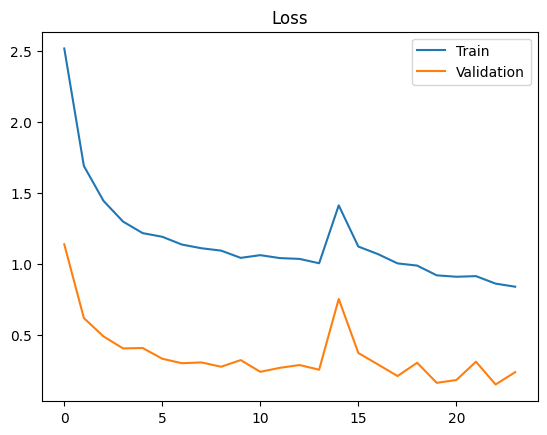

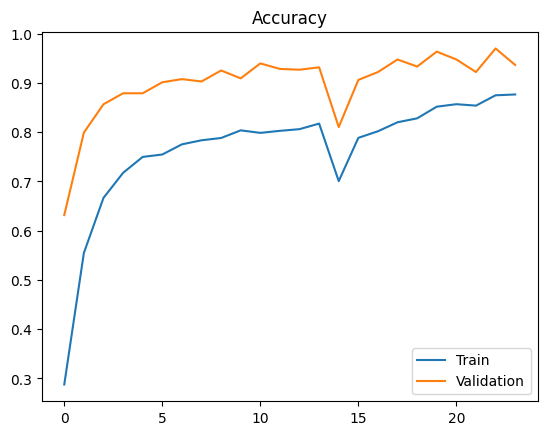

-0.05986136198043823


In [16]:
loss_train_curve = history_stage1.history["loss"]+history_stage2.history["loss"]
loss_val_curve = history_stage1.history["val_loss"]+history_stage2.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = history_stage1.history["accuracy"]+history_stage2.history["accuracy"]
acc_val_curve = history_stage1.history["val_accuracy"]+history_stage2.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()
gap=acc_train_curve[-1]-acc_val_curve[-1]
print(gap)

### 성능 평가

In [17]:
test_loss, test_acc = q_aware_model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

83/83 [==============================] - 12s 142ms/step - loss: 0.2493 - accuracy: 0.9397
The test loss is:  0.24933157861232758
The best accuracy is:  93.96681785583496


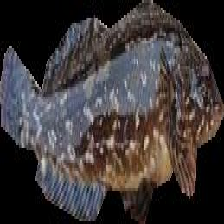

In [18]:
test_img = tf.keras.preprocessing.image.load_img('/home/juha/Desktop/S12P21C201/src/AI/dataset/mix_data/data_split/test/노래미/노래미_4949.jpg', 
                                            target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(test_img)
img_array = np.array([img_array]) 
test_img

In [19]:
# generate predictions for samples
predictions = q_aware_model.predict(img_array)
print(predictions)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

# transform classes number into classes name
print(class_names[class_id.item()])

1/1 [==============================] - 2s 2s/step
[[4.3147347e-06 2.0208345e-05 1.1236087e-04 1.7022458e-05 3.9069312e-07
  6.3625656e-09 9.9899822e-01 1.3339010e-04 7.2190442e-06 1.1916280e-06
  4.7011963e-06 1.4146508e-06 2.8867682e-04 3.1031421e-05 3.6345082e-06
  2.3990477e-05 7.9725731e-05 2.3990477e-05 4.0138806e-05 4.7011963e-06
  1.5206840e-07 3.3810837e-05 1.2242480e-04 2.3990477e-05 1.2983595e-06
  2.2018343e-05]]
[6]
노래미


### 전처리기 추가

In [20]:
final_input=tf.keras.Input(shape=(224, 224, 3), name='image_input')

x=preprocess_input(final_input)

final_output=q_aware_model(x)
 
q_aware_model=tf.keras.Model(inputs=final_input, outputs=final_output)

### 모델 저장

In [21]:
# directory
q_aware_model.save('/home/juha/Desktop/S12P21C201/src/AI/models/50model/QAT_50model_mixed')

# or h5 file
#model.save('/home/juha/Desktop/S12P21C201/src/AI/models/101model/QAT_101model_h5')

converter=tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model=converter.convert()


with open('QAT_50model_mixed.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /home/juha/Desktop/S12P21C201/src/AI/models/50model/QAT_50model_mixed/assets


INFO:tensorflow:Assets written to: /home/juha/Desktop/S12P21C201/src/AI/models/50model/QAT_50model_mixed/assets


INFO:tensorflow:Assets written to: /tmp/tmp3mdayq2z/assets


INFO:tensorflow:Assets written to: /tmp/tmp3mdayq2z/assets
/home/juha/miniconda3/envs/tf_pjt/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-02 16:23:45.929017: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-02 16:23:45.929053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-02 16:23:45.929271: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3mdayq2z
2025-04-02 16:23:45.960963: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-02 16:23:45.960998: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp3mdayq2z
2025-04-02 16:23:46.049408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimiza

In [22]:
# # model load
# tf.keras.models.load_model('AI/model2/second_model')
# model.summary()